# Team SML

In [162]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
from sklearn.neighbors import KNeighborsRegressor
import seaborn as sns

In [192]:


url = 'https://raw.githubusercontent.com/cividi/st-gallen-urban-indicators/main/data/price-monitoring/price-monitoring-extended.csv'
df = pd.read_csv(url, index_col=0)

print(df)

mycols = ['rent','lat', 'lng', 'LR_DAY', 'LR_NIGHT', 'area', 'year_built', 'quartier_quartiergr']
# df = df[mycols]


# quartiers = df["quartier_quartiergr"].astype('category')
#df["quartier_quartiergr"] = df["quartier_quartiergr"].astype('category').cat.codes

# print(df.corr())


# df["noise"] = df.apply(lambda row: row.LR_DAY + row.LR_NIGHT, axis=1)

# df = df.dropna()

#df = df.drop(['LR_DAY', 'LR_NIGHT'],  axis=1)

#df_train, df_test = train_test_split(df)

model = smf.ols(formula='rent ~ area + year_built', data=df_train).fit()
print(model.summary())

regr = LinearRegression()
regr.fit(X=df_train[['area', 'year_built']], y=df_train['rent'])
res = regr.score(X=df_test[['area', 'year_built']], y=df_test['rent'])
print(res)

neigh = KNeighborsRegressor(n_neighbors=1)
neigh.fit(X=df_train[['area', 'year_built']], y=df_train['rent'])
neigh.score(X=df_test[['area', 'year_built']], y=df_test['rent'])

                                                   object_ref category  \
id                                                                       
108761792                                         hgok2876852     rent   
2147994348  44.53.3003.499622.e75b7976-c57b-11e9-9cb0-a4bf...     rent   
3000166218                                    21301.01.420030     rent   
3000251780                                        hgoe3023792     rent   
3000402506                                      03159.01.0132     rent   
...                                                       ...      ...   
3001465599                                      01707.01.3002     rent   
3001467270                                       6102.01.0101     rent   
3001468434        912039.28f0a8cb-3daa-11ec-842e-005056bdbc06     rent   
3001470695                                      83565.02.0103     rent   
3001470708                                       8902.04.0039     rent   

                           date  flat

0.7182506065383986

## Welche Faktoren haben einen Einfluss auf die Miete?

### area
Wie der folgende Plot zeigt, gibt es einen deutlichen linearen Zusammenhang zwischen rent und area.

<AxesSubplot:xlabel='area', ylabel='rent'>

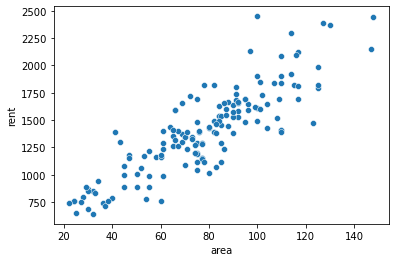

In [163]:
sns.scatterplot(data=df, x="area", y = "rent")

### year_built
Es gibt eine Korrelation zwischen year_built und rent, diese ist allerdings nicht wirklich linear.

<AxesSubplot:xlabel='year_built', ylabel='rent'>

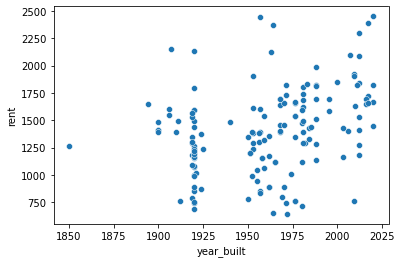

In [164]:
sns.scatterplot(data=df, x="year_built", y = "rent")

### ren_potential
Dieses Attribut sagt aus, ob eine Liegenschaft seit der Erstellung renoviert wurde.

<AxesSubplot:xlabel='ren_potential', ylabel='rent'>

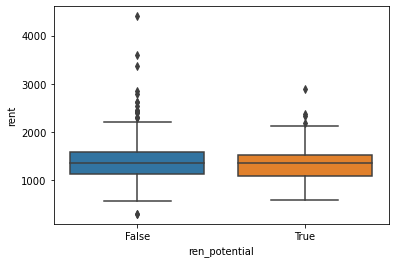

In [190]:
sns.boxplot(x="ren_potential", y="rent", data=df)

### LR_DAY und LR_NIGHT
Diese Attribute geben die Lärmbelasting in Dezibel währen des Tages und der Nacht an. Die Lärmbelastung korreliert nicht mit der rent.

<AxesSubplot:xlabel='LR_DAY', ylabel='rent'>

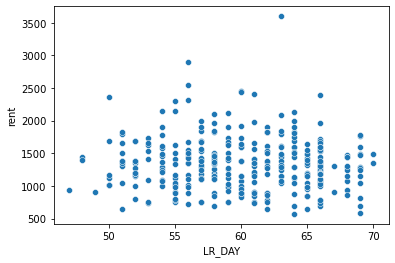

In [212]:
sns.scatterplot(data=df, x="LR_DAY", y = "rent")

<AxesSubplot:xlabel='LR_NIGHT', ylabel='rent'>

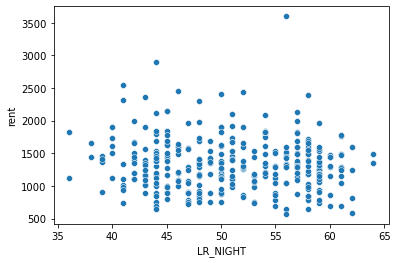

In [213]:
sns.scatterplot(data=df, x="LR_NIGHT", y = "rent")

### quartier_quartiergr
Der Median ist bei allen Quartieren ähnlich.

[Text(0, 0, 'St.Georgen'),
 Text(1, 0, 'Langgass-Heiligkreuz'),
 Text(2, 0, 'St.Fiden'),
 Text(3, 0, 'Lachen'),
 Text(4, 0, 'Innenstadt'),
 Text(5, 0, 'Riethüsli'),
 Text(6, 0, 'Bruggen'),
 Text(7, 0, 'Linsenbühl-Dreilinden'),
 Text(8, 0, 'Rotmonten'),
 Text(9, 0, 'St.Jakob'),
 Text(10, 0, 'Neudorf'),
 Text(11, 0, 'Notkersegg'),
 Text(12, 0, 'Rosenberg'),
 Text(13, 0, 'Winkeln')]

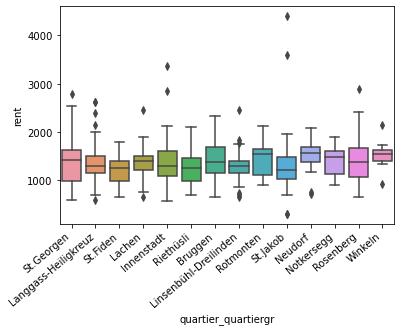

In [209]:
plt = sns.boxplot(x="quartier_quartiergr", y="rent", data=df)
plt.set_xticklabels(plt.get_xticklabels(), rotation=40, ha="right")